# Installs

In [ ]:
%%time
!pip install --upgrade tf2onnx
!pip install onnx onnxruntime torch
!pip install onnx2pytorch # Install the onnx2pytorch package
from IPython.display import clear_output  # Import clear_output from IPython.display

clear_output()


CPU times: user 150 ms, sys: 19.1 ms, total: 169 ms
Wall time: 14.8 s


# Imports

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam




# Load data

In [ ]:
data=pd.read_csv('data.csv')

In [ ]:
data.shape

(4688, 10)

In [ ]:
data.isnull().sum()


,0
id,0
temperature,0
pressure,0
altitude,0
soilmiosture,0
note,0
status,0
class,0
date,0
time,0


In [ ]:
data= data.drop_duplicates()


In [ ]:
data.columns

Index(['id', 'temperature', 'pressure', 'altitude', 'soilmiosture', 'note',
       'status', 'class', 'date', 'time'],
      dtype='object')

# Check for outliers

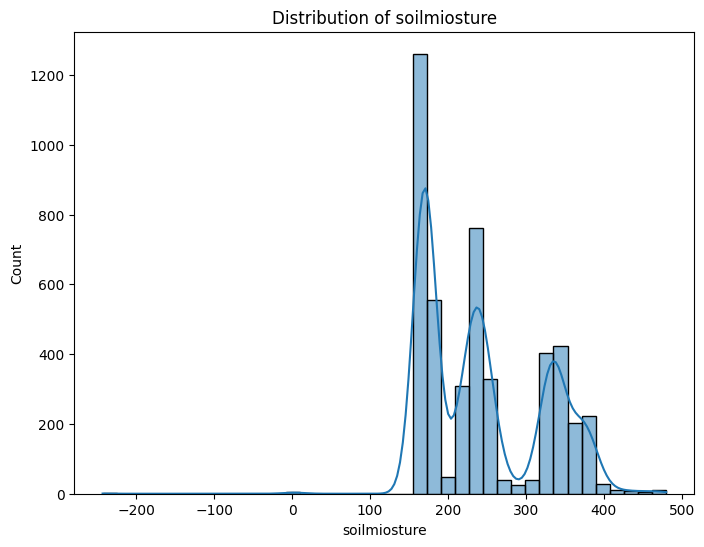

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data['soilmiosture'], kde=True)
plt.title('Distribution of soilmiosture')
plt.show()

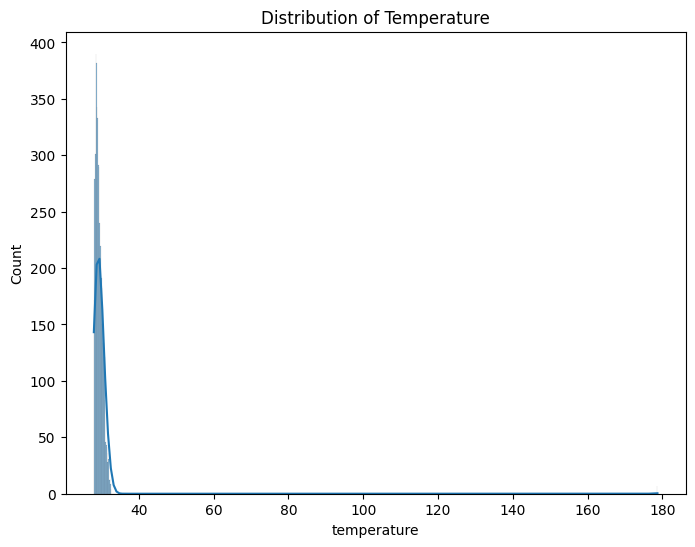

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data['temperature'], kde=True)
plt.title('Distribution of Temperature')
plt.show()

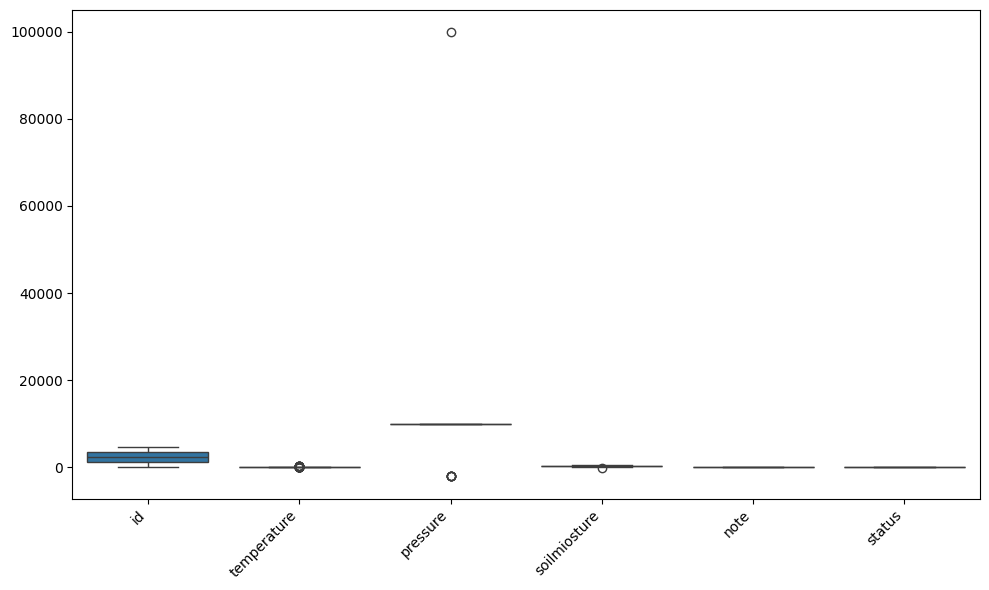

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create boxplot
plt.figure(figsize=(10,6))  # Adjust figure size if necessary
sns.boxplot(data)

# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
data.describe()

,id,temperature,pressure,soilmiosture,note,status
count,4688.000000,4688.000000,4688.000000,4688.000000,4688.000000,4688.000000
mean,2344.500000,29.599089,9963.153215,243.692406,1.878413,0.703712
std,1353.453361,5.842685,1383.602527,76.176855,1.152977,0.456668
min,1.000000,27.970000,-2120.400000,-243.000000,0.000000,0.000000
25%,1172.750000,28.630000,9935.255000,171.000000,1.000000,0.000000
50%,2344.500000,29.180000,9969.535000,233.000000,2.000000,1.000000
75%,3516.250000,29.990000,9975.700000,326.000000,3.000000,1.000000
max,4688.000000,178.700000,99931.100000,480.000000,3.000000,1.000000


In [ ]:
def detect_outliers_iqr(df):
    # Calculer les percentiles
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Calculer les bornes inférieure et supérieure
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Détecter les valeurs aberrantes
    outliers = (df < lower_bound) | (df > upper_bound)
    return outliers

# Appliquer la détection d'outliers à chaque colonne
outliers = detect_outliers_iqr(data[['temperature', 'pressure', 'soilmiosture']])
print(outliers.sum())  # Affiche le nombre d'outliers pour chaque colonne


temperature     45
pressure         7
soilmiosture     1
dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# Supposons que vous ayez déjà détecté les outliers et que `outliers` est un masque boolean pour chaque colonne.
outliers = detect_outliers_iqr(data[['temperature', 'pressure', 'soilmiosture']])

# Supprimer les lignes qui contiennent des outliers
data = data[~outliers.any(axis=1)]

# Afficher les statistiques descriptives après suppression des outliers
print(data.describe())


                id  temperature     pressure  soilmiosture         note  \
count  4643.000000  4643.000000  4643.000000   4643.000000  4643.000000   
mean   2345.396295    29.352270  9959.409222    243.726470     1.881973   
std    1349.506139     0.907561    21.753562     75.204029     1.150588   
min       1.000000    27.970000  9920.360000    157.000000     0.000000   
25%    1188.500000    28.620000  9935.430000    171.000000     1.000000   
50%    2349.000000    29.170000  9969.440000    233.000000     2.000000   
75%    3509.500000    29.960000  9975.675000    326.000000     3.000000   
max    4688.000000    32.030000  9994.160000    480.000000     3.000000   

            status  
count  4643.000000  
mean      0.705148  
std       0.456026  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  


In [ ]:
# Drop rows with null values, if any
data.dropna(inplace=True)

# Drop unnecessary columns (like id, date, and time)
data = data.drop(['id', 'note', 'status', 'date', 'time', 'pressure', 'altitude'], axis=1)

# Encode the target column 'class'
label_encoder = LabelEncoder()
data['class'] = label_encoder.fit_transform(data['class'])



<ipython-input-374-c031ccbdcc85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [ ]:
data['class'].value_counts()

,count
class,
2,1826
3,1448
1,1005
0,364


# Separate features and target

In [ ]:
# Separate features and target
X = data.drop('class', axis=1)
y = data['class']

# Normalisation des caractéristiques

In [ ]:
# Normalisation des caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **2. Construction du modèle**
input_dim = X_train.shape[1]  # Nombre de caractéristiques d'entrée
num_classes = len(np.unique(y))  # Nombre de classes de sortie

# Construction du modèle avec régularisation et Dropout

In [ ]:
# **2. Construction du modèle avec régularisation et Dropout**
model = Sequential([
    # Première couche dense avec régularisation L2 et Dropout
    Dense(64, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),  # Dropout à 30% pour éviter le sur-apprentissage

    # Deuxième couche dense avec régularisation L2 et Dropout
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),

    # Troisième couche dense avec régularisation L2 et Dropout
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),

    # Couche de sortie avec activation softmax
    Dense(num_classes, activation='softmax')  # Softmax pour la classification multi-classes
])

# **3. Compilation du modèle**
optimizer = Adam(learning_rate=0.001)  # Optimiseur Adam avec taux d'apprentissage défini
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# **4. Ajout de l'early stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# **5. Entraînement du modèle avec validation et early stopping**
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# **6. Évaluation du modèle sur l'ensemble de test**
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4518 - loss: 1.8630 - val_accuracy: 0.8210 - val_loss: 1.1290
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7611 - loss: 1.1435 - val_accuracy: 0.9125 - val_loss: 0.6905
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8535 - loss: 0.8174 - val_accuracy: 0.9152 - val_loss: 0.5410
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8788 - loss: 0.6470 - val_accuracy: 0.9206 - val_loss: 0.4520
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8889 - loss: 0.5533 - val_accuracy: 0.9192 - val_loss: 0.4071
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8957 - loss: 0.5031 - val_accuracy: 0.9206 - val_loss: 0.3777
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9000 - loss: 0.4631 - val_accuracy: 0.9219 - val_loss: 0.3524
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8968 - loss: 0.4522 - val_accuracy: 0.9233 - 

In [ ]:
"""

# Build a deep learning model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model with sparse_categorical_crossentropy for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")"""


'\n\n# Build a deep learning model\nmodel = Sequential([\n    Dense(64, activation=\'relu\', input_shape=(X_train.shape[1],)),\n    Dense(32, activation=\'relu\'),\n    Dense(16, activation=\'relu\'),\n    Dense(num_classes, activation=\'softmax\')  # Softmax activation for multi-class classification\n])\n\n# Compile the model with sparse_categorical_crossentropy for multi-class classification\nmodel.compile(optimizer=\'adam\', loss=\'sparse_categorical_crossentropy\', metrics=[\'accuracy\'])\n\n# Train the model\nmodel.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)\n\n# Evaluate the model\nloss, accuracy = model.evaluate(X_test, y_test)\nprint(f"Test Accuracy: {accuracy:.2f}")'

# Evaluation

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1938 
Test Accuracy: 0.97


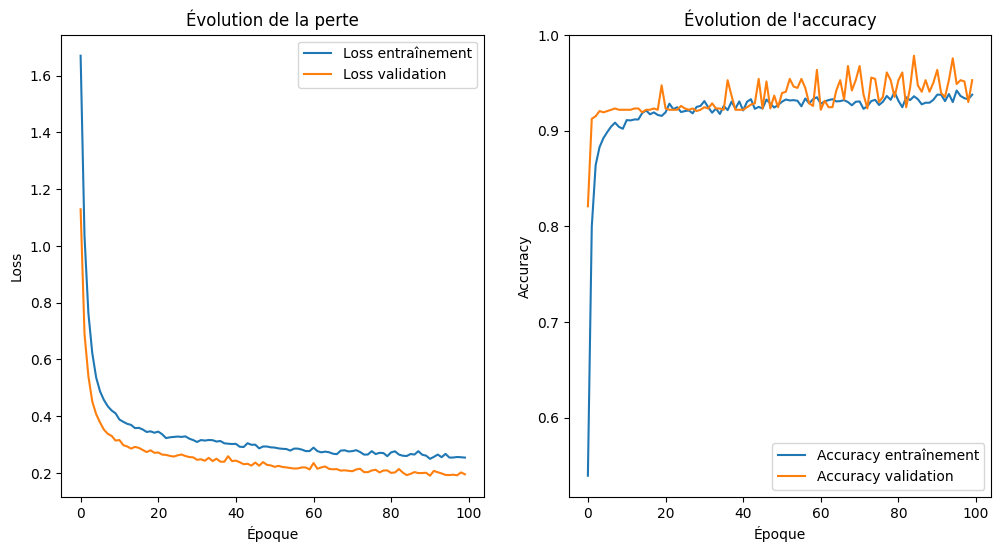

In [ ]:
# **4. Évaluation du modèle**
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# **5. Visualisation des performances**
plt.figure(figsize=(12, 6))

# Courbes de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title("Évolution de la perte")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

# Courbes d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title("Évolution de l'accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


# Test

In [ ]:
# Exemple de données à prédire
new_data = pd.DataFrame({
    'temperature': [20],         # Température du sol
    'soilmiosture': [200],      # Humidité du sol (par exemple, 30%)
})

# Normalisation des nouvelles données
new_data_scaled = scaler.transform(new_data)

# Prédiction
predictions = model.predict(new_data_scaled)

# Obtenir la classe prédite
predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])

print(f"Predicted class: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: Wet


# Save model

In [ ]:
import tensorflow as tf

model.save('saved_model.keras')  # Use .keras extension (recommended)

# Load the SavedModel. Note that we also adjusted the load path to match the above
model = tf.keras.models.load_model('saved_model.keras')

In [ ]:
import tensorflow as tf
import tf2onnx
import onnx # Import the onnx module

# Load your Keras model
model = tf.keras.models.load_model('saved_model.keras')

# Get the output tensor of the last layer
output_tensor = model.layers[-1].output

# Create a new Keras model with a named output
new_model = tf.keras.models.Model(inputs=model.inputs, outputs=[output_tensor], name="new_model")
# Give the output a name
new_model._outputs[0]._name = "output_0"

# Get input shape and create spec
input_shape = new_model.input_shape
spec = (tf.TensorSpec(input_shape, tf.float32),)

# Convert to ONNX using the new model with the named output
onnx_model, _ = tf2onnx.convert.from_keras(new_model, input_signature=spec, opset=13)

# Save the ONNX model using onnx.save
onnx.save(onnx_model, "model.onnx") # Call onnx.save to save the model

In [ ]:
import torch
import onnx
import onnx2pytorch

# Charger le modèle ONNX
onnx_model = onnx.load("model.onnx")

# Convertir le modèle ONNX en modèle PyTorch
pytorch_model = onnx2pytorch.ConvertModel(onnx_model)

# Sauvegarder le modèle PyTorch
torch.save(pytorch_model.state_dict(), 'model.pt')
